In [1]:
# general imports
import numpy
import pandas

# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}') 

from pyfoomb import BioprocessModel
from pyfoomb import Caretaker
from pyfoomb import Measurement
from pyfoomb import Visualization

C:\Users\hemmerich\AppData\Local\Continuum\miniconda3\envs\pyfoomb-dev\lib\site-packages\assimulo\solvers\odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


This notebook will demonstrate how to implement models with irregular events. Such could be, e.g., removing or adding volumes for sampling or adding an inducer. 

Thanks due to full programmatic access, we are able to modify the behavior of the user-implemented `BioprocessModell` subclassses.

The first example will demonstrate the basic principle. It will be necessary to use an own constructor (the `__init__()` method) in the user-sepcific model class. Because the `pyFOOMB` package relies on a specific instantiation of the `BioprocessModel` (sub-)class, this method must be called also in the new `__init__()` methods with forwarding all arguments.

As running example, the model introduced in the example notebook on events is used

# 1. Bioprocess model with irregular events

In [2]:
# Defines the model class
class SequentialKinetic_01(BioprocessModel):
    
    def __init__(self, *args, **kwargs):

        # defines the sampling timepoints
        self.t_samplings = [
            5,   
            18.3,
            20.0,
        ]
        # assumes the same volume removal for all samplings
        self.V_sampling = 0.1
        
        # calls the constructor of the BioprocessModel base class, forwarding all arguments
        BioprocessModel.__init__(self, *args, **kwargs)  
        
    
    def rhs(self, t, y, sw):
        A, B, C, VL = y
        
        k1 = self.model_parameters['k1']
        if sw[0]:
            k2 = self.model_parameters['k2']
        else:
            k2 = 0

        dAdt = -k1*A
        dBdt = k1*A - k2*B
        dCdt = k2*B
        dVLdt = 0
        return [dAdt, dBdt, dCdt, dVLdt]
    

    def state_events(self, t, y, sw):
        t_add = self.model_parameters['t_add']
        event_t = t_add - t 
        events = [event_t]
        
        # construct the sampling events, and add them to the other event
        events_samplings = [t-t_sampling for t_sampling in self.t_samplings]  
        events.extend(events_samplings)
        return events
    
    def change_states(self, t, y, sw):
        A, B, C, VL = y
        
        # first condition: any event is hit, second condition: the current timepoint must be a sampling timepoint
        if any(sw) and (t in self.t_samplings):
            # remove the sampling volume
            VL = VL - self.V_sampling
            
        return [A, B, C, VL]
    
initial_values = {
    'A0' : 50.0,
    'B0' : 0.0,
    'C0' : 0.0,
    'VL0' : 1.0
}

model_parameters = {
    'k1' : 0.2,
    'k2' : 0.1,
    't_add' : 10.0,
}

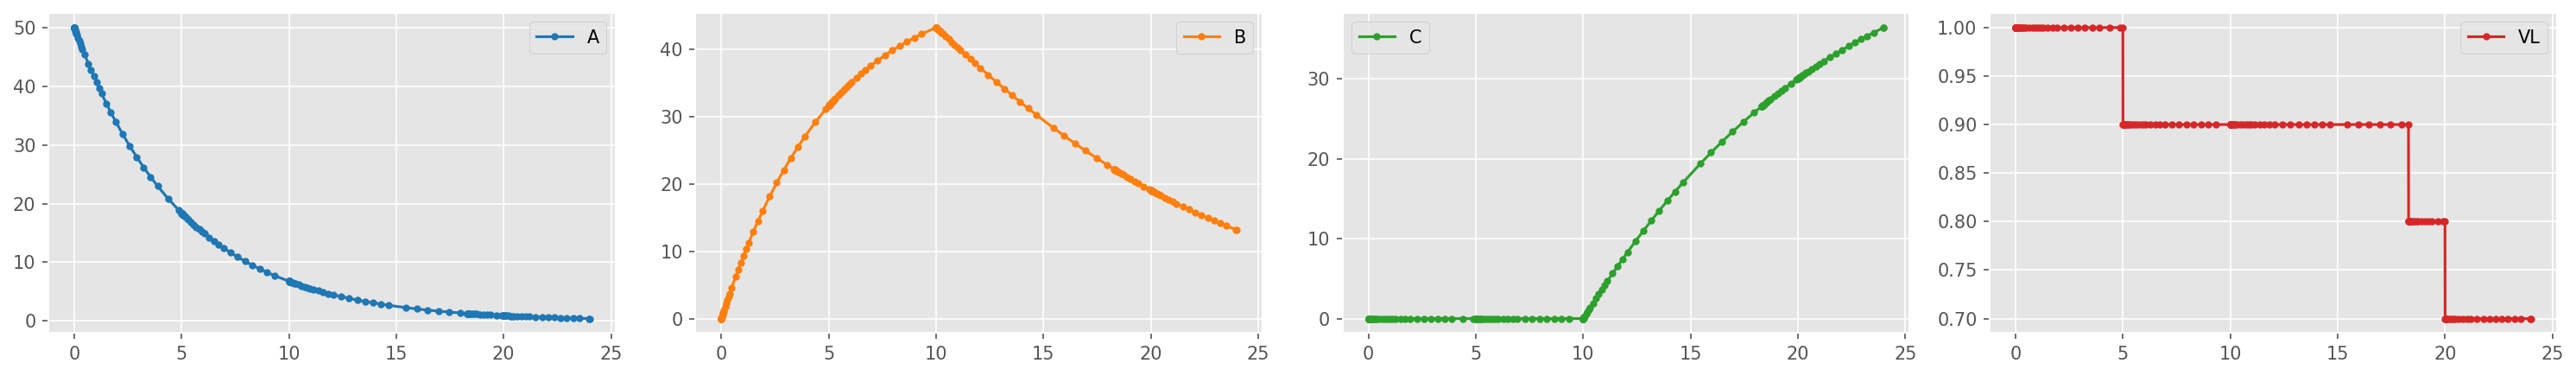

In [3]:
caretaker = Caretaker(
    bioprocess_model_class=SequentialKinetic_01, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

simulation = caretaker.simulate(t=24)
_ = Visualization.show_kinetic_data(simulation, ncols=4)

As we can see nicely, the irregular volume changes match the sampling times that were defined in the `__init__()` method of the corresponding model class.

# 2. Different event timepoints for different replicates

The second example will show how to implement different sampling timepoints (i.e., event timepoint) for each replicate when working with replicates.

In [4]:
# Defines the replicate_ids
replicate_ids = ['R1', 'R2']

In [5]:
# Inherits from the first bioprocess model example
class SequentialKinetic_02(SequentialKinetic_01):
    
    def __init__(self, *args, **kwargs):
        
        # When working with different replicates, the `replicate_id` member must be assigned at the very beginning
        self.replicate_id = kwargs['replicate_id']
        
        # There are the sampling times for the different replicates maintained
        # This implies that all replicate_ids are known a priori
        self.t_samplings_dict = {
            'R1' : [5, 18.3, 20.0],
            'R2' : [1, 2, 12.5],
        }
        # Select the sampling timetable for the current replicate_id
        self.t_samplings = self.t_samplings_dict[self.replicate_id]
    
        # The sampling volume will be the same
        self.V_sampling = 0.1
        
        # Call the constructor of the BioprocessModel class, passing the necessary arguments
        # Thus, the construction of the first bioprocess model example is "skipped", as it would interfere
        BioprocessModel.__init__(self, *args, **kwargs)  

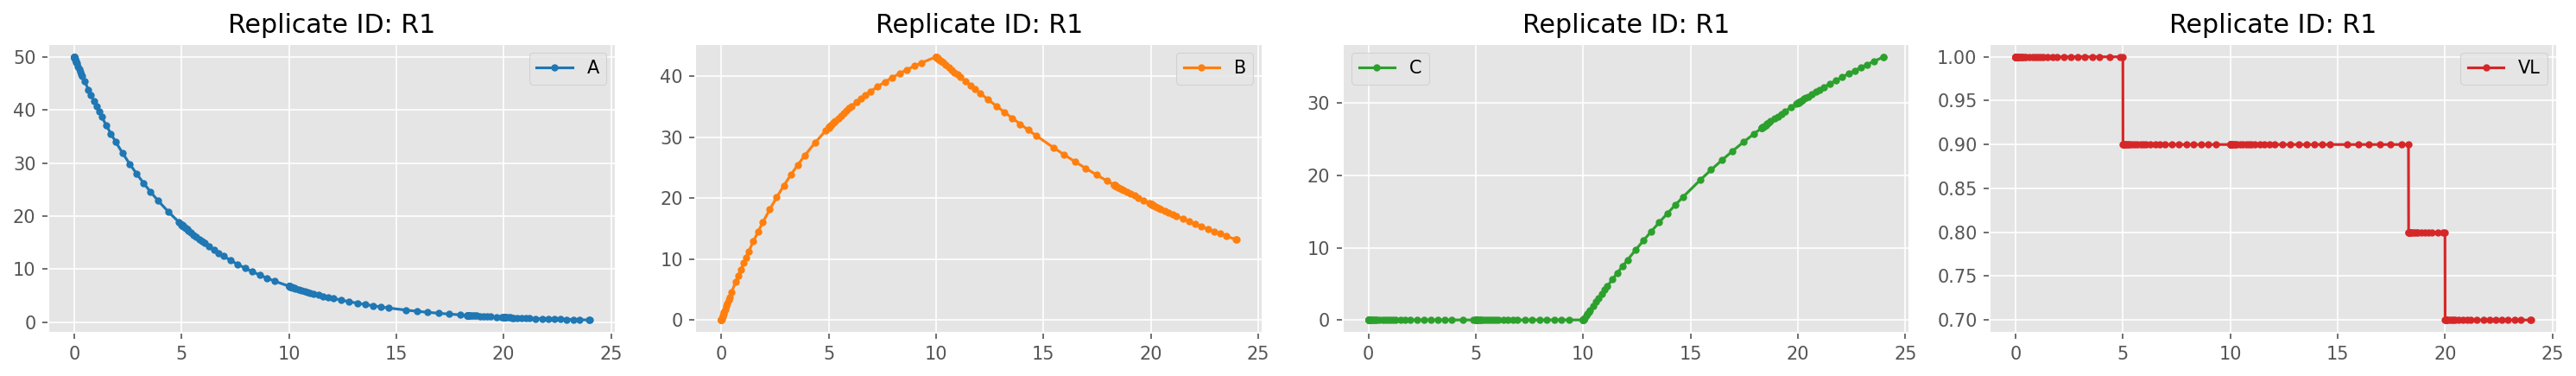

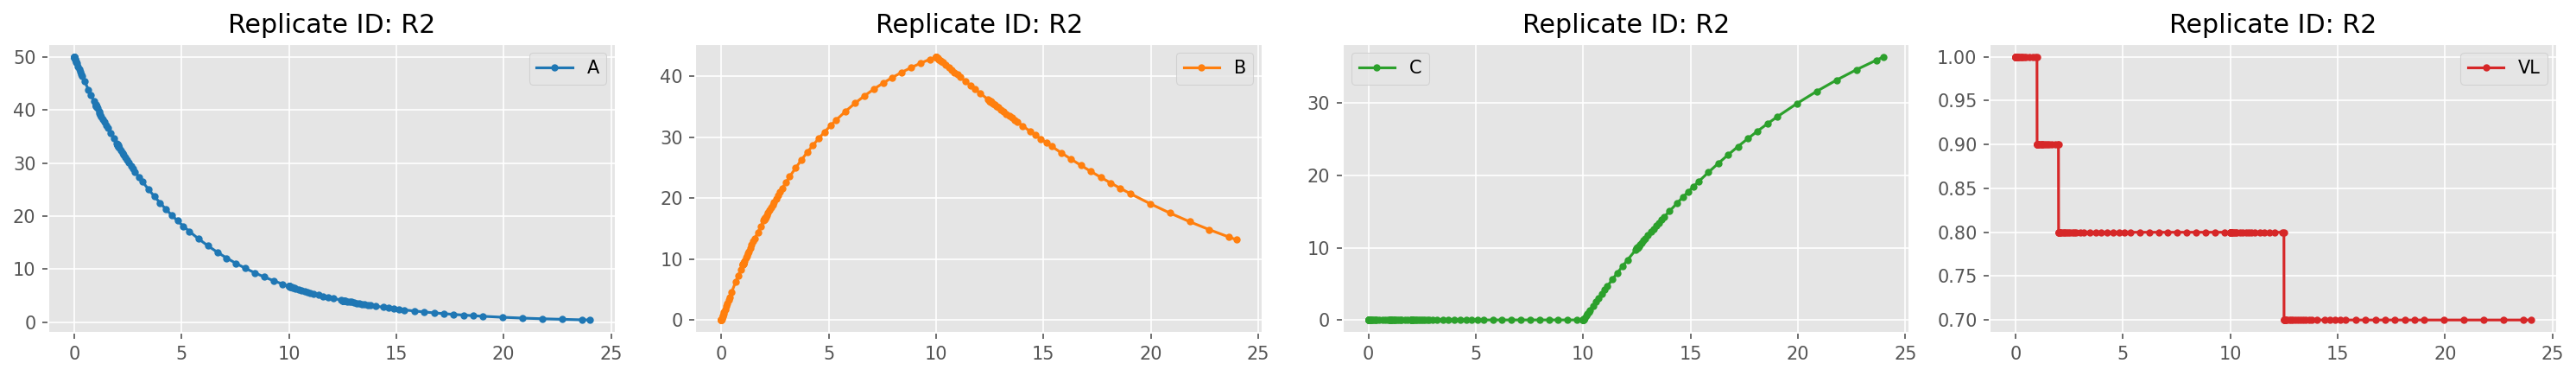

In [6]:
caretaker = Caretaker(
    bioprocess_model_class=SequentialKinetic_02, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
    replicate_ids=replicate_ids
)

simulation = caretaker.simulate(t=24)
_ = Visualization.show_kinetic_data(simulation, ncols=4)

This time, we demonstrated that different sampling timepoints (a.k.a. event timepoints) can be realized for each `replicate_id`. To make this possible, we must define the `replicate_ids` *a priori*, because adding further replicates alter on breaks the used mechanism.

# 3. Different number of irregular events for different replicates

The number of event timepoint can also vary for each replicate.

In [7]:
class SequentialKinetic_03(SequentialKinetic_01):
    
    def __init__(self, *args, **kwargs):
        
        # When working with different replicates, the `replicate_id` member must be assigned at the very beginning
        self.replicate_id = kwargs['replicate_id']
        
        # There are the sampling times for the different replicates maintained
        # This implies that all replicate_ids are known a priori
        self.t_samplings_dict = {
            'R1' : [5, 7.9],
            'R2' : [1, 2, 12.5, 15, 18, 19],
        }
        # Select the sampling timetable for the current replicate_id
        self.t_samplings = self.t_samplings_dict[self.replicate_id]
    
        # The sampling volume will be the same
        self.V_sampling = 0.1
        
        # Call the constructor of the BioprocessModel class, passing the necessary arguments
        # Thus, the construction of the first bioprocess model example is "skipped", as it would interfere
        BioprocessModel.__init__(self, *args, **kwargs)  

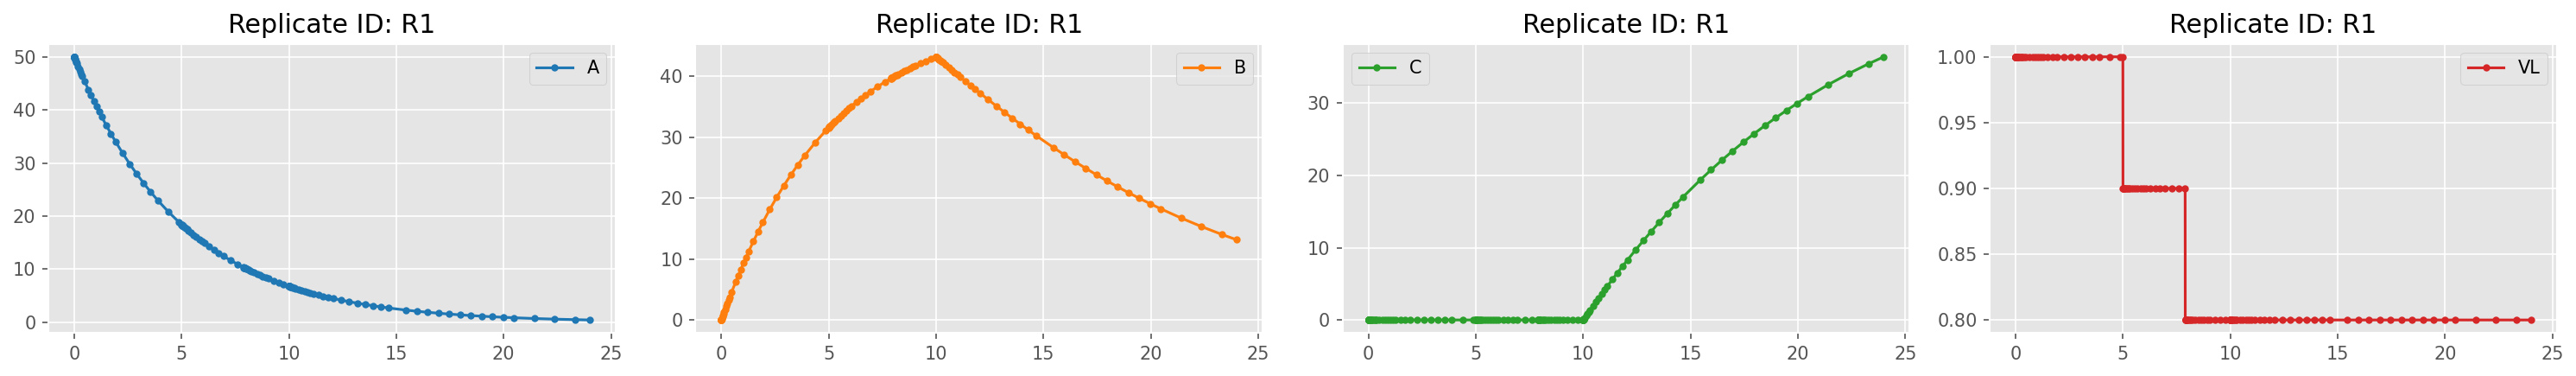

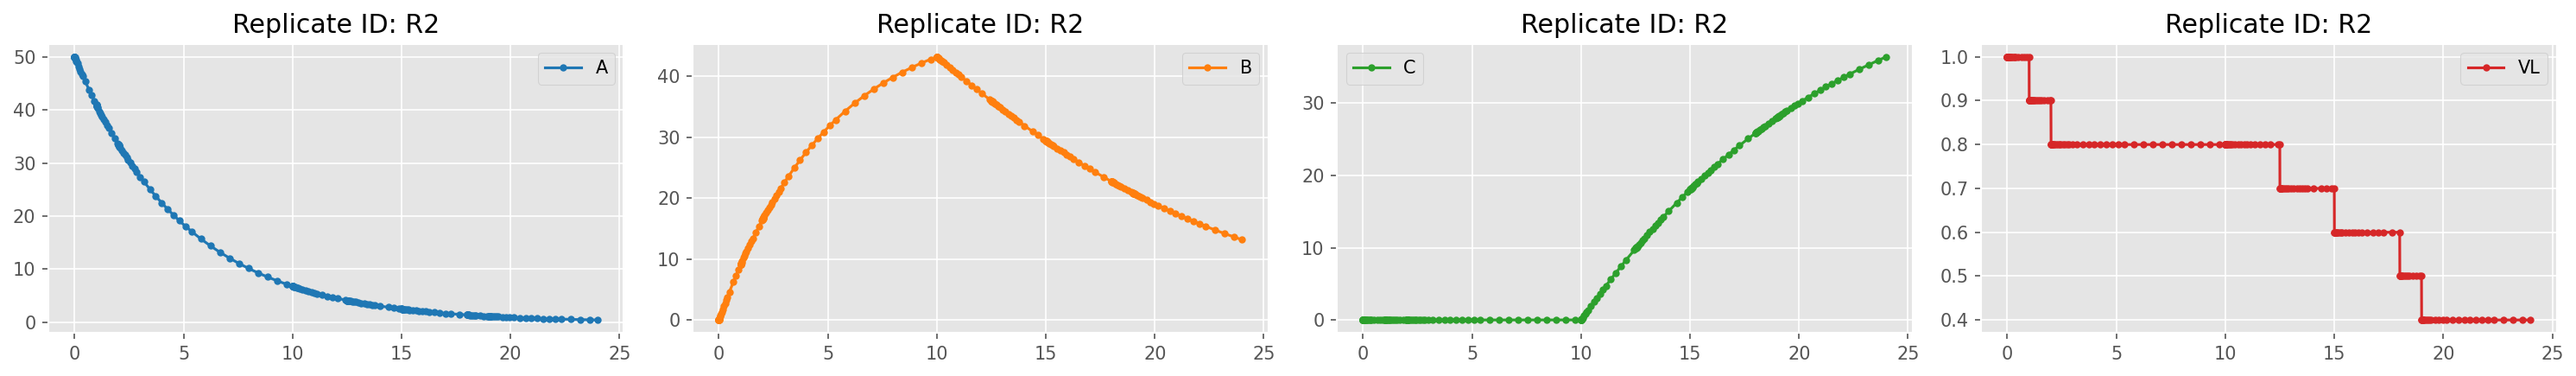

In [8]:
caretaker = Caretaker(
    bioprocess_model_class=SequentialKinetic_03, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
    replicate_ids=replicate_ids
)

simulation = caretaker.simulate(t=24)
_ = Visualization.show_kinetic_data(simulation, ncols=4)

In addition to the second example, it is demonstrated that different replicates can have different timepoints of events, as well as number of events. To make this work, the model must be formulated in a way that autodetection of number of events works. This is the case, where the call of the method `state_events()` raises no exception when the `sw` argument is `None`.

# 4. Reading measurement data with different samplings for each replicate

As spreadsheet data is often used to read measurement data needed for parameter estimation, the fourth example will demonstrate how to extract the corresponding sampling timepoints (and thus, event timepoints) for different measurements and replicates. This assumes that all entries in the spreadsheet correspond to a sampling event. 

This apporoach relies on standard Python techniques using, e.g. pandas. 

In [9]:
filename = 'example17_data.xlsx'
dfs = pandas.read_excel(filename, header=[0, 1], index_col=0, sheet_name=None)

# Create an empty list, which will collect all Measurement objects
measurements = []

# Create an empty dictionary, which will collect all measurement timepoints (i.e., sampling timepoint)
samplings_from_spreadsheet = {}

# Iterate over replicates
for _replicate_id in dfs.keys():
    _df = dfs[_replicate_id]
    
    # Collect measurement timepoints for this replicate
    samplings_from_spreadsheet[_replicate_id] = _df.index.to_numpy(dtype=float)
    
    names = numpy.unique([mi[0] for mi in _df.columns])
    for name in names:
        # Create corresponding Measurement object
        _measurement = Measurement(
            name=name, 
            replicate_id = _replicate_id,  
            timepoints=_df.index, 
            values=_df[(name, 'values')].to_numpy(), 
            errors=_df[(name, 'errors')].to_numpy(),
        )
        # Append measurement to list
        measurements.append(_measurement)

In [10]:
# Have a look at the extracted sampling timepoints
samplings_from_spreadsheet

{'R1': array([ 1.,  2., 19.]), 'R2': array([ 5. , 17.5, 18. , 19. ])}

In [11]:
class SequentialKinetic_04(SequentialKinetic_01):
    
    def __init__(self, *args, **kwargs):
        
        # When working with different replicates, the `replicate_id` member must be assigned at the very beginning
        self.replicate_id = kwargs['replicate_id']
        
        # Select the sampling timetable for the current replicate_id
        self.t_samplings = samplings_from_spreadsheet[self.replicate_id]
    
        # The sampling volume will be the same
        self.V_sampling = 0.1
        
        # Call the constructor of the BioprocessModel class, passing the necessary arguments
        # Thus, the construction of the first bioprocess model example is "skipped", as it would interfere
        BioprocessModel.__init__(self, *args, **kwargs)  

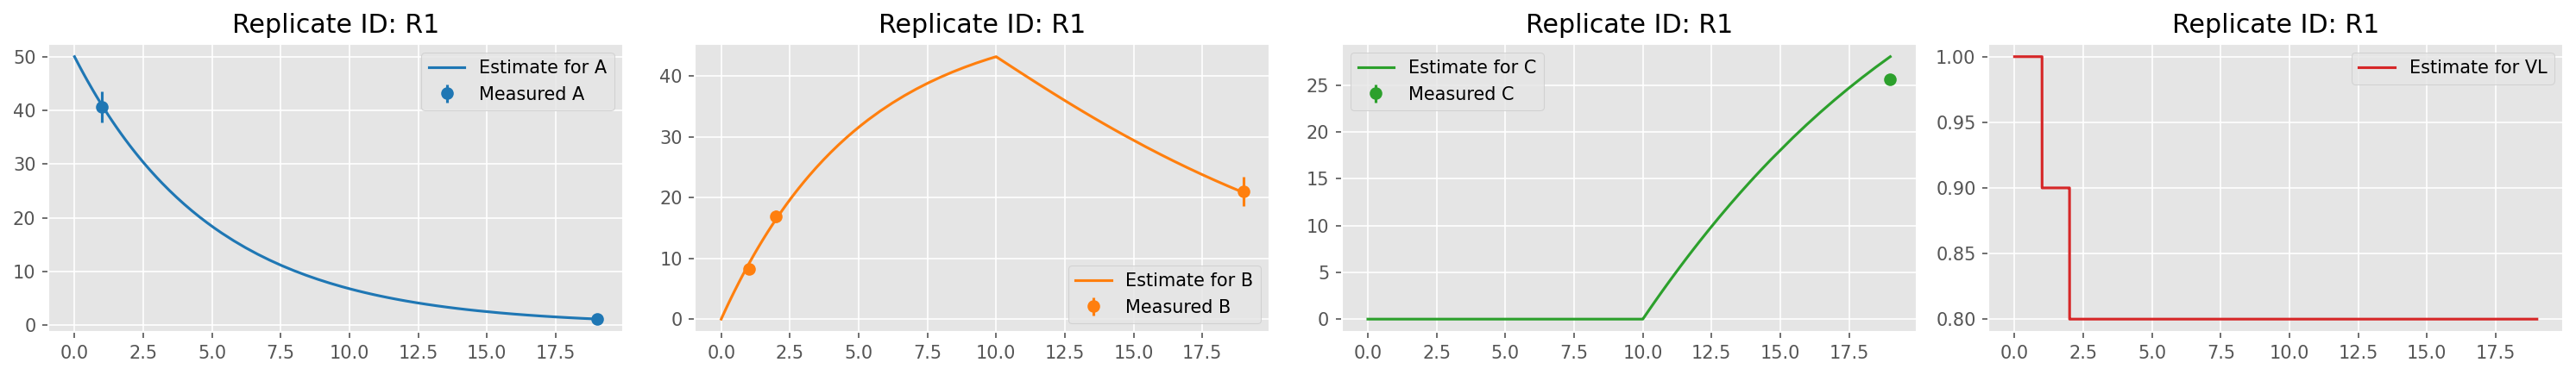

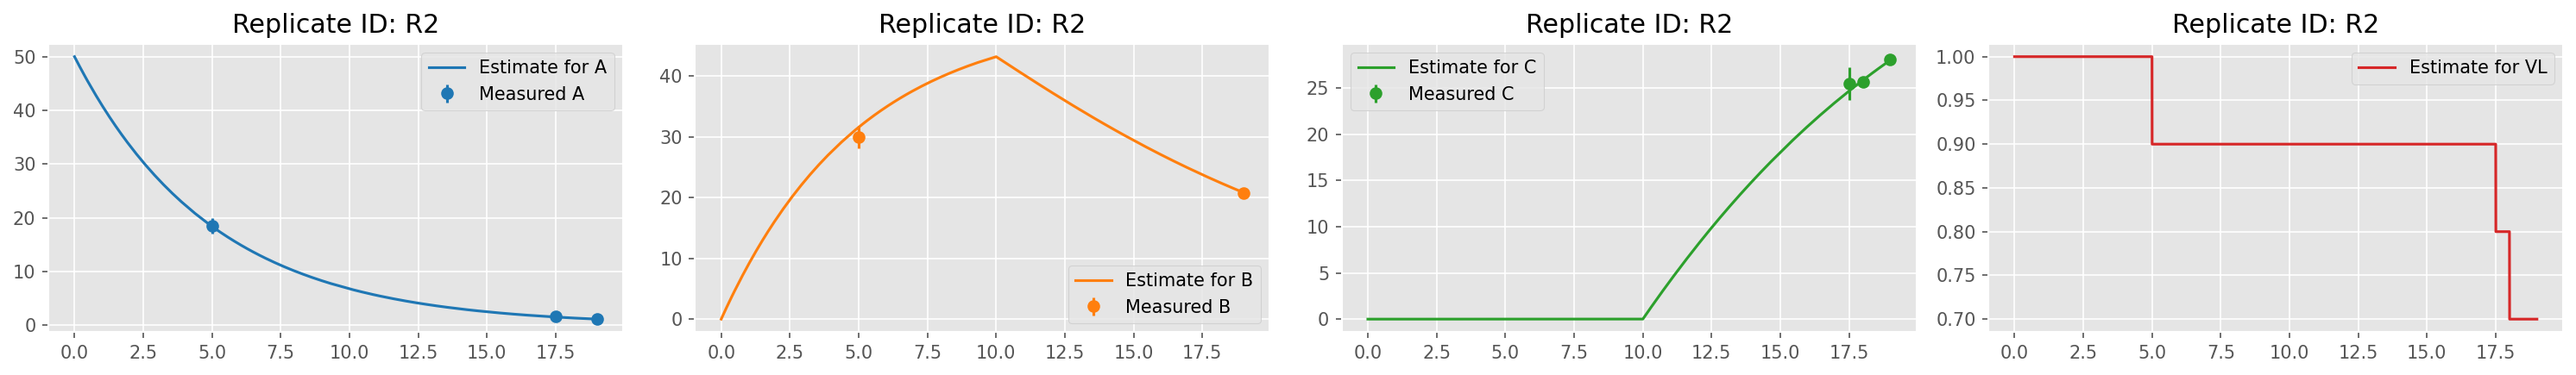

In [12]:
caretaker = Caretaker(
    bioprocess_model_class=SequentialKinetic_04, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
    replicate_ids=replicate_ids
)

simulation = caretaker.simulate(t=24)
_ = Visualization.compare_estimates({}, measurements=measurements, caretaker=caretaker, ncols=4)

# NOTE: Volume drop at last sampling timepoint is not seen, because simulation stops at this point

Finally, we will run a parameter estimation.

In [13]:
unknowns = ['k2', 'B0', 't_add']
bounds = [(0, 10), (0, 5), (7.5, 12.5)]

est, est_info = caretaker.estimate_parallel(
    unknowns=unknowns,
    bounds=bounds,
    measurements=measurements,
    report_level=1,
    evolutions=25,
)

Creating archipelago with 12 islands. May take some time...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    2.5s remaining:   13.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    2.7s finished


Running 25 evolutions for all 12 islands of the archipelago...

.............
Reached a stopping criterion after evolution 13:
convergence: True
max_runtime: False
max_evotime: False
max_memory_share: False

Estimated parameters:
B0: 1.4002619040377151e-09
k2: 0.10317360523811328
t_add: 10.304068310153454

-------------Finished evolution 13-------------
Current best loss: 17.900287532401713
Average loss among the islands: 17.900292 +/- 0.000004 (0.000022 %)

Total runtime was 0.68 min



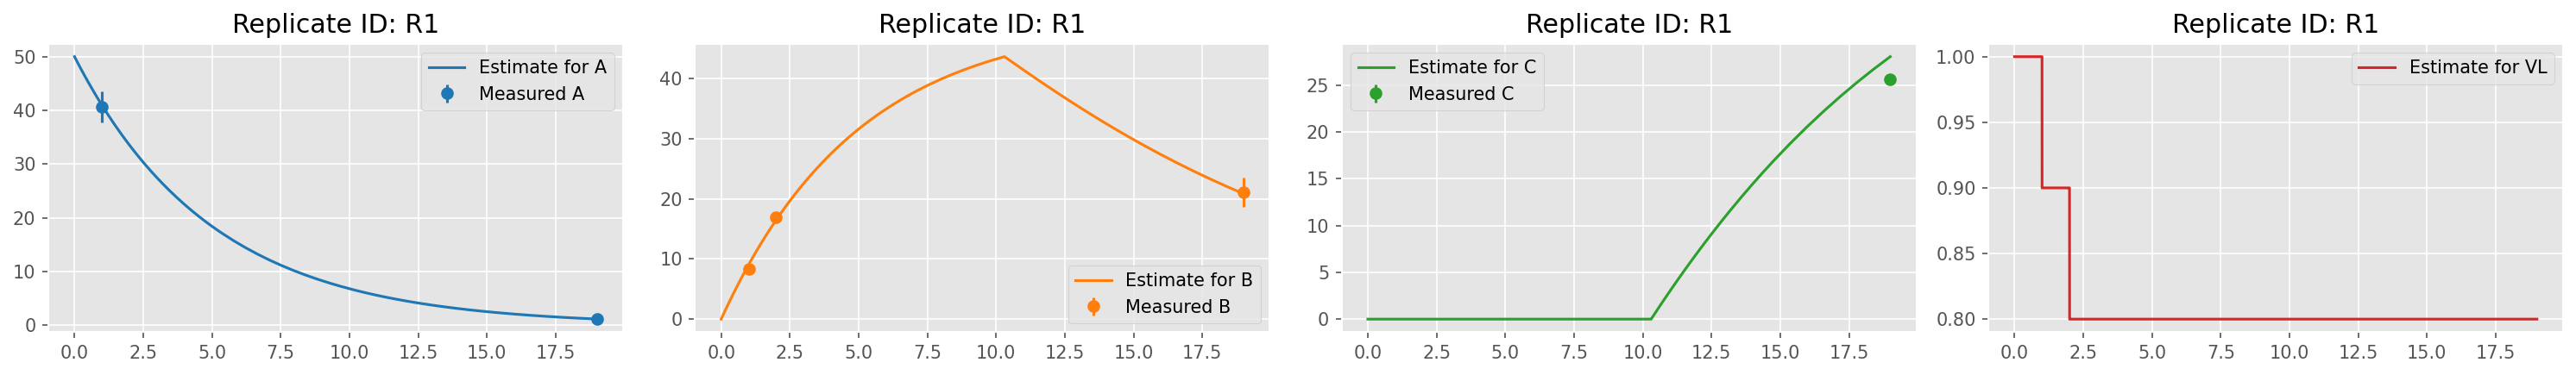

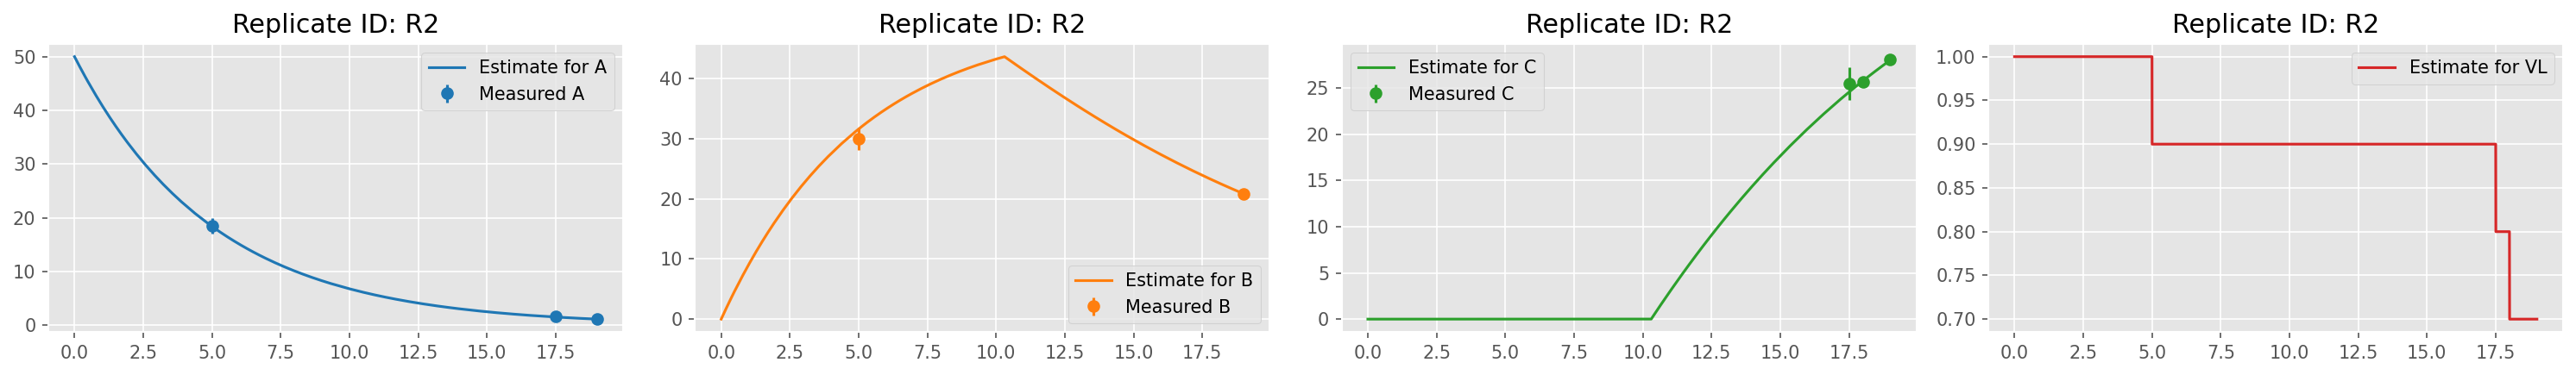

In [14]:
_ = Visualization.compare_estimates(est, measurements=measurements, caretaker=caretaker, ncols=4)

Parameter estimation works as expected!

# 5. Notes

In case volume data is also contained in the spreadsheet data from timepoints where __NO__ samples have been taken, some more standard Python coding (using, e.g. pandas, etc.) is needed to filter those timepoints where samples were taken. The basic approach shown here in example #4 interprets any time point found in the spreadsheet as sampling timepoint.

What won't work:
* Adding a `replicated_id` after creating the `Caretaker`
* Model where the autodetection of the number of events fails (which is a really rare case)